In [1]:
import sys

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [3]:
import sandbox
from algorithms import ChainTopology, RingTopology, QuadraticsTask, relaysum_model, relaysum_grad, relaysum_mix, all_reduce, gossip, d2, gradient_tracking, BinaryTreeTopology, relaysum_grad_overlap
from random_quadratics import RandomQuadraticsTask
import torch
import math
import tuning
import pandas as pd

# Playing with correction factors

In [ ]:
import torch

"""
Compute learning rate correction for RelaySum/Model
to compensate for energy loss
"""

class CorrectionFactorTask:
    def __init__(
        self, num_workers: int
    ):
        self.num_workers = num_workers
        self.name = f"Delivery"
        self.error_metric = "Mean relative squared consensus distance"
        self.i = 0

    def init_state(self):
        return torch.zeros(self.num_workers, 1, 1)

    def grad(self, state):
        grad = torch.zeros_like(state)
        if self.i == 0:
            grad = -1
        self.i += 1

        return grad

    def error(self, state):
        """Mean relative squared consensus distance"""
        return torch.mean((state - state.mean(axis=0, keepdims=True)) ** 2) / torch.mean(state.mean(axis=0, keepdims=True)**2)

def compute_lr_correction(topology, algorithm):
    task = CorrectionFactorTask(num_workers=topology.num_workers)
    for iterate in algorithm(task, world=topology, num_steps=10000, learning_rate = 1):
        x = iterate.state
        if torch.std(x) < 1e-4 and iterate.step > 0:
            break
    return (1 / torch.mean(x)).item()

In [47]:
sizes = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80]
corrections = []
for size in sizes:
    corrections.append(compute_lr_correction(BinaryTreeTopology(size), relaysum_model))
corrections_chain = []
for size in sizes:
    corrections_chain.append(compute_lr_correction(ChainTopology(size), relaysum_model))

In [48]:
import networkx as nx
def max_delay(topo):
    g = topo.to_networkx()
    distances = dict(nx.all_pairs_shortest_path_length(g))
    return max(distances[i][j] for i in g.nodes for j in g.nodes)

delays = []
for size in sizes:
    delays.append(max_delay(BinaryTreeTopology(size)) / 2)
delays_chain = []
for size in sizes:
    delays_chain.append(max_delay(ChainTopology(size)) / 2)


In [49]:
colors = sns.color_palette("tab10")

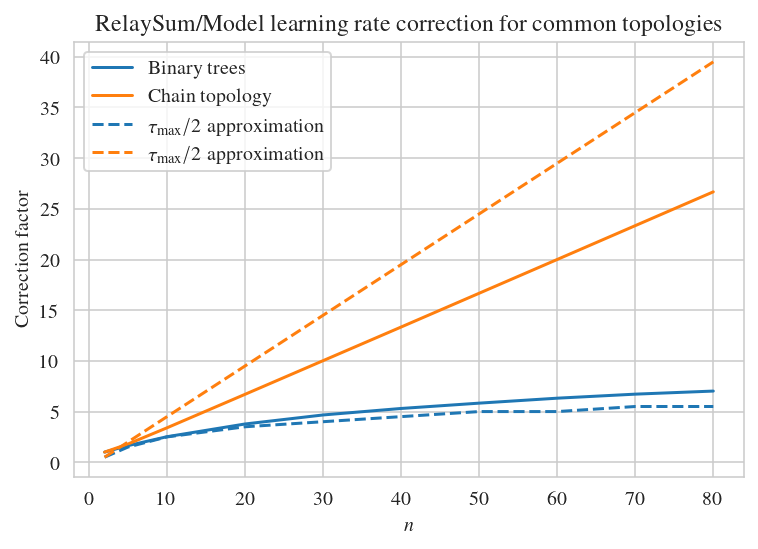

In [50]:
plt.plot(sizes, corrections, label="Binary trees")
plt.plot(sizes, corrections_chain, label="Chain topology")
plt.plot(sizes, delays, "--", label=r"$\tau_\text{max}/2$ approximation", c=colors[0])
plt.plot(sizes, delays_chain, "--", label=r"$\tau_\text{max}/2$ approximation", c=colors[1])
plt.xlabel("$n$")
plt.ylabel("Correction factor")
plt.title("RelaySum/Model learning rate correction for common topologies")
plt.legend();
plt.savefig("relaysum_model_correction_factor.pdf", bbox_inches="tight", pad_inches = 0)